In [86]:
import os
import tempfile

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import src as ddfa_node
import ray
from ray import train, tune
from ray.train import Checkpoint, ScalingConfig
from ray.train.torch import TorchTrainer, get_device
from ray.tune.examples.mnist_pytorch import ConvNet, get_data_loaders, test_func
from ray.tune.schedulers import PopulationBasedTraining
from torchdiffeq import odeint
from hyperopt import hp

import numpy as np

import sys
sys.path.append('/home/michael/Synology/Desktop/Data/Python/Gait-Signatures/NeuralODE/DDFA_NODE/')


def train_convnet(config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Create our data loaders, model, and optmizer.
    step = 1
    batch_size = config.get("batch_size", 32)
    latent_dim = config.get("latent_dim", 32)
    timesteps_per_sample = config.get("timesteps_per_sample", 150)
    n_hidden = 32
    dec_hidden = 16
    rnn_hidden = config.get("rnn_hidden", 64)
    dec_dropout = config.get("dec_dropout", 0.1)
    
    n_itrs = 1000
    train_loader, test_loader, (_, tot_num, obs_dim) = get_dataloaders(batch_size, timesteps_per_sample=timesteps_per_sample, device=device)
    ts_num = 4.5

    samp_ts = np.linspace(0, ts_num, num=tot_num)
    samp_ts = torch.from_numpy(samp_ts).float().to(device)
    
    func = ddfa_node.LatentODEfunc(latent_dim, n_hidden).to(device)
    rec = ddfa_node.RecognitionRNN(latent_dim, obs_dim, rnn_hidden, batch_size).to(device)
    dec = ddfa_node.Decoder(latent_dim, obs_dim, dec_hidden, dropout=dec_dropout).to(device)
    
    
    model = NODE(func, rec, dec, latent_dim, odeint, samp_ts, device)
    
    optimizer = optim.Adam(
        model.parameters(),
        lr=config.get("lr", 0.01),
    )
    loss_fn = torch.nn.MSELoss()
    # If `train.get_checkpoint()` is populated, then we are resuming from a checkpoint.
    checkpoint = train.get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            checkpoint_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))

        # Load model state and iteration step from checkpoint.
        model.load_state_dict(checkpoint_dict["model_state_dict"])
        # Load optimizer state (needed since we're using momentum),
        # then set the `lr` and `momentum` according to the config.
        optimizer.load_state_dict(checkpoint_dict["optimizer_state_dict"])
        for param_group in optimizer.param_groups:
            if "lr" in config:
                param_group["lr"] = config["lr"]
            if "momentum" in config:
                param_group["momentum"] = config["momentum"]
            if "batch_size" in config:
                param_group["batch_size"] = config["batch_size"]
            if "latent_dim" in config:
                param_group["latent_dim"] = config["latent_dim"]
            if "rnn_hidden" in config:
                param_group["rnn_hidden"] = config["rnn_hidden"]

        # Note: Make sure to increment the checkpointed step by 1 to get the current step.
        last_step = checkpoint_dict["step"]
        step = last_step + 1

    while True:
        for data in train_loader:
            optimizer.zero_grad()
            pred_X = model(data)
            
            loss = loss_fn(pred_X, data)
            loss.backward()
            optimizer.step()
        
        losses = torch.zeros(len(test_loader))
        for idx, data in enumerate(test_loader):
            pred_X = model(data)
            test_loss = loss_fn(pred_X, data)
            losses[idx] = test_loss
        metrics = {"test_loss": -1*torch.mean(losses).detach().numpy(), "lr": config["lr"]}

        # Every `checkpoint_interval` steps, checkpoint our current state.
        if step % config["checkpoint_interval"] == 0:
            with tempfile.TemporaryDirectory() as tmpdir:
                torch.save(
                    {
                        "step": step,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                    },
                    os.path.join(tmpdir, "checkpoint.pt"),
                )
                train.report(metrics, checkpoint=Checkpoint.from_directory(tmpdir))
        else:
            train.report(metrics)

        step += 1

In [87]:
class NODE(torch.nn.Module):
    def __init__(self, func, rec, dec, latent_dim, odeint, samp_ts, device):
        super(NODE, self).__init__()
        self.func = func
        self.rec = rec
        self.dec = dec
        self.latent_dim = latent_dim
        self.odeint = odeint
        self.samp_ts = samp_ts
        self.device = device

    def forward(self, x):
        h = self.rec.initHidden().to(self.device)
        c = self.rec.initHidden().to(self.device)
        hn = h[0, :, :]
        cn = c[0, :, :]
        for t in reversed(range(x.size(1))):
            obs = x[:, t, :]
            out, hn, cn = self.rec.forward(obs, hn, cn)
        qz0_mean, qz0_logvar = out[:, :self.latent_dim], out[:, self.latent_dim:]
        epsilon = torch.randn(qz0_mean.size()).to(self.device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean   

        # forward in time and solve ode for reconstructions
        pred_z = self.odeint(self.func, z0, self.samp_ts).permute(1, 0, 2)
        pred_x = self.dec(pred_z)

        return pred_x
    
def get_dataloaders(batch_size, device, timesteps_per_sample=150, data_path = "/home/michael/Synology/Desktop/Data/Julia/data/human_data.npy"):
    data = ddfa_node.load_data_normalize(6, data_path)
    # time_delayed_data, k, τ = ddfa_node.embed_data(data, maxlags=500)
    τ, k = 19, 9
    time_delayed_data = ddfa_node.takens_embedding(data, τ, k)
    
    # Train/test splitting
    train_size = 0.7
    data_train, data_val = ddfa_node.split_data(time_delayed_data, train_size=train_size)

    # Subsample whole trials to smaller ones
    
    data_train, data_val = ddfa_node.change_trial_length(data_train, timesteps_per_subsample=timesteps_per_sample), ddfa_node.change_trial_length(data_val, timesteps_per_subsample=timesteps_per_sample)

    # Add noise to data
    # noise_std = 0.05
    # data_train = ddfa_node.augment_data_with_noise(data_train, n_copies=5, noise_std=noise_std)

    data_train, data_val = torch.from_numpy(data_train).float() .to(device), torch.from_numpy(data_val).float() .to(device)
    train_loader = DataLoader(dataset = data_train, batch_size = batch_size, shuffle = True, drop_last = True)
    val_loader = DataLoader(dataset = data_val, batch_size = batch_size, shuffle = True, drop_last = True)
    return train_loader, val_loader, data_train.shape

In [91]:
perturbation_interval = 50
scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    perturbation_interval=perturbation_interval,
    metric="test_loss",
    mode="max",
    hyperparam_mutations={
        # distribution for resampling
        "lr": tune.loguniform(5e-5, 1e-2),
        "dec_dropout": tune.uniform(0.01, 0.4)
        # allow perturbations within this set of categorical values

    },
)

In [4]:
if ray.is_initialized():
    ray.shutdown()
ray.init(runtime_env={"working_dir": "/home/michael/Synology/Desktop/Data/Python/Gait-Signatures/NeuralODE/DDFA_NODE/"})

2024-03-28 22:32:45,881	INFO worker.py:1743 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
2024-03-28 22:32:45,885	INFO packaging.py:530 -- Creating a file package for local directory '/home/michael/Synology/Desktop/Data/Python/Gait-Signatures/NeuralODE/DDFA_NODE/'.
2024-03-28 22:32:45,888	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_0e792d4ec59ec2ee.zip' (0.66MiB) to Ray cluster...
2024-03-28 22:32:45,890	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_0e792d4ec59ec2ee.zip'.


Python version:,3.11.7
Ray version:,2.10.0
Dashboard:,http://127.0.0.1:8265


In [ ]:
trainable_with_gpu = tune.with_resources(train_convnet, {"gpu": 0.15})
# trainable_with_gpu = tune.with_resources(train_convnet, {"cpu": 1})


tuner = tune.Tuner(
    trainable_with_gpu,
    run_config=train.RunConfig(
        name="pbt_test2",
        # Stop when we've reached a threshold accuracy, or a maximum
        # training_iteration, whichever comes first
        # stop={"test_loss": 0.05, "training_iteration": 2500},
        stop={"test_loss": -0.15, "training_iteration": 500},
        checkpoint_config=train.CheckpointConfig(
            checkpoint_score_attribute="test_loss",
            num_to_keep=10,
        ),
        storage_path="/tmp/ray_results2",
    ),
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        num_samples=300,
        max_concurrent_trials=6
    ),
    param_space={
        "lr": tune.uniform(1e-5, 1e-2),
        "latent_dim": tune.choice([2**x for x in range(3, 6)]),
        "rnn_hidden": tune.choice([2**x for x in range(5, 9)]),
        "batch_size": tune.choice([16, 32]),
        "timesteps_per_trial": tune.choice([50, 150, 300, 500]),
        "checkpoint_interval": perturbation_interval,
    },
)

results_grid = tuner.fit()

(train_convnet pid=1314526) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_results2/pbt_test2/train_convnet_47bad_00005_5_batch_size=16,latent_dim=8,lr=0.0004,rnn_hidden=64,timesteps_per_trial=150_2024-03-30_15-47-02/checkpoint_000000)
(train_convnet pid=1314521) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_results2/pbt_test2/train_convnet_47bad_00000_0_batch_size=16,latent_dim=8,lr=0.0023,rnn_hidden=64,timesteps_per_trial=50_2024-03-30_15-47-02/checkpoint_000000)
(train_convnet pid=1314524) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_results2/pbt_test2/train_convnet_47bad_00003_3_batch_size=16,latent_dim=32,lr=0.0031,rnn_hidden=256,timesteps_per_trial=300_2024-03-30_15-47-02/checkpoint_000000)
(train_convnet pid=1314523) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_results2/pbt_test2/train_convnet_47bad_00002_2_batch_size=16,latent_dim=8,lr=0.0064,rnn_

In [37]:
results_grid

ResultGrid<[
  Result(
    metrics={'test_loss': -0.5824124813079834, 'lr': 0.03324752662410935},
    path='/tmp/ray_results2/pbt_test2/train_convnet_1f5f5_00000_0_batch_size=64,latent_dim=16,lr=0.0332,rnn_hidden=64_2024-03-29_18-03-06',
    filesystem='local',
    checkpoint=Checkpoint(filesystem=local, path=/tmp/ray_results2/pbt_test2/train_convnet_1f5f5_00000_0_batch_size=64,latent_dim=16,lr=0.0332,rnn_hidden=64_2024-03-29_18-03-06/checkpoint_000004)
  ),
  Result(
    metrics={'test_loss': -0.49420610070228577, 'lr': 0.004978841777485692},
    path='/tmp/ray_results2/pbt_test2/train_convnet_1f5f5_00001_1_batch_size=16,latent_dim=64,lr=0.0751,rnn_hidden=128_2024-03-29_18-03-06',
    filesystem='local',
    checkpoint=Checkpoint(filesystem=local, path=/tmp/ray_results2/pbt_test2/train_convnet_1f5f5_00001_1_batch_size=16,latent_dim=64,lr=0.0751,rnn_hidden=128_2024-03-29_18-03-06/checkpoint_000004)
  ),
  Result(
    metrics={'test_loss': -0.6404941082000732, 'lr': 0.04613984906869787}

In [66]:
import seaborn as sns

In [81]:
max_iterations = df.groupby("trial_id")["training_iteration"].max()

# Select the rows corresponding to the maximum iteration number for each trial
selected_rows = df[df.apply(lambda row: row["training_iteration"] == max_iterations[row["trial_id"]], axis=1)]

# Create a new dataframe with the selected rows
new_df = pd.DataFrame(selected_rows)

# Optionally, reset the index of the new dataframe
new_df.reset_index(drop=True, inplace=True)
new_df

,test_loss,lr,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,...,time_since_restore,iterations_since_restore,config/lr,config/latent_dim,config/rnn_hidden,config/batch_size,config/timesteps_per_trial,config/checkpoint_interval,should_checkpoint,logdir
0,-1.026965,0.000072,1711753866,checkpoint_000000,False,5,94ef3_00000,2024-03-29_19-11-06,1.270650,14.199342,...,14.199342,5,0.003319,8,256,16,300.0,5,True,94ef3_00000
1,-0.470402,0.000451,1711755766,checkpoint_000000,False,30,94ef3_00001,2024-03-29_19-42-46,21.402877,292.935829,...,114.994006,5,0.000451,16,32,16,NaN,5,True,94ef3_00001
2,-1.016573,0.000892,1711753863,checkpoint_000000,False,5,94ef3_00002,2024-03-29_19-11-03,1.746309,10.984298,...,10.984298,5,0.004780,8,256,16,500.0,5,True,94ef3_00002
3,-0.398125,0.004979,1711755762,checkpoint_000000,False,30,94ef3_00003,2024-03-29_19-42-42,19.682986,268.300347,...,101.970174,5,0.004979,8,256,16,NaN,5,True,94ef3_00003
4,-0.637435,0.002878,1711755033,None,False,11,94ef3_00004,2024-03-29_19-30-33,12.743719,39.231714,...,12.743719,1,0.002878,8,128,32,150.0,5,NaN,94ef3_00004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,-0.994132,0.001302,1711755016,None,False,6,94ef3_00145,2024-03-29_19-30-16,8.707373,14.193412,...,8.707373,1,0.001302,32,64,32,300.0,5,NaN,94ef3_00145
146,-0.661874,0.003212,1711755108,checkpoint_000001,False,10,94ef3_00146,2024-03-29_19-31-48,18.468826,113.697350,...,97.266498,5,0.003212,8,256,16,50.0,5,True,94ef3_00146
147,-1.027830,0.000345,1711754521,checkpoint_000000,False,5,94ef3_00147,2024-03-29_19-22-01,0.610775,5.347224,...,5.347224,5,0.000345,8,64,64,150.0,5,True,94ef3_00147
148,-0.587594,0.012972,1711755818,checkpoint_000000,False,25,94ef3_00148,2024-03-29_19-43-38,35.600773,378.774764,...,173.307294,5,0.012972,8,32,16,NaN,5,True,94ef3_00148


<Axes: xlabel='config/latent_dim', ylabel='test_loss'>

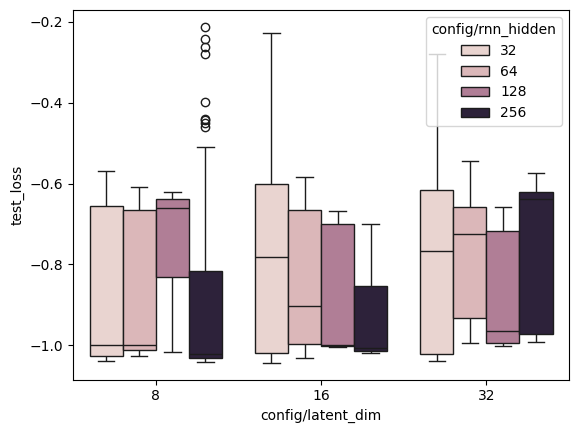

In [83]:
df = results_grid.get_dataframe()
df.groupby(by="config/latent_dim")
# df.head()
sns.boxplot(x="config/latent_dim", y="test_loss", hue="config/rnn_hidden", data=new_df)

Best result path: /tmp/ray_results2/pbt_test2/train_convnet_94ef3_00125_125_batch_size=32,latent_dim=8,lr=0.0000,rnn_hidden=128,timesteps_per_trial=150_2024-03-29_19-10-49
Best final iteration hyperparameter config:
 {'lr': 0.002212818567771419, 'latent_dim': 8, 'rnn_hidden': 256, 'batch_size': 16, 'checkpoint_interval': 5}


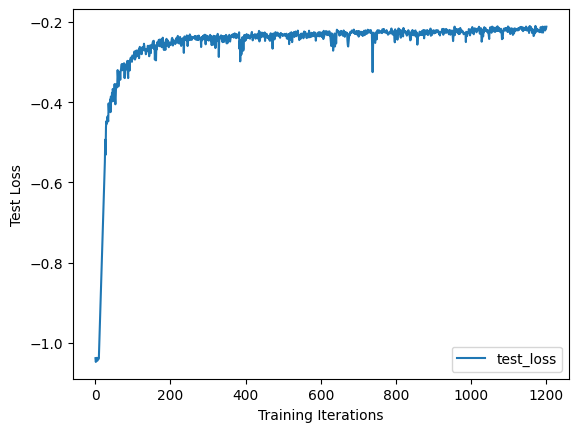

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

# Get the best trial result
best_result = results_grid.get_best_result(metric="test_loss", mode="max")

# Print `path` where checkpoints are stored
print('Best result path:', best_result.path)

# Print the best trial `config` reported at the last iteration
# NOTE: This config is just what the trial ended up with at the last iteration.
# See the next section for replaying the entire history of configs.
print("Best final iteration hyperparameter config:\n", best_result.config)

# Plot the learning curve for the best trial
df = best_result.metrics_dataframe
# Deduplicate, since PBT might introduce duplicate data
df = df.drop_duplicates(subset="training_iteration", keep="last")
df.plot("training_iteration", "test_loss")
plt.xlabel("Training Iterations")
plt.ylabel("Test Loss")
plt.show()

In [49]:
best_result = results_grid.get_best_result(metric="test_loss", mode="max")
with best_result.checkpoint.as_directory() as checkpoint_dir:
    state_dict = torch.load(os.path.join(checkpoint_dir, "model.pth"))

model = NODE(func, rec, dec)
model.load_state_dict(state_dict)

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/ray_results2/pbt_test2/train_convnet_94ef3_00125_125_batch_size=32,latent_dim=8,lr=0.0000,rnn_hidden=128,timesteps_per_trial=150_2024-03-29_19-10-49/checkpoint_000380/model.pth'

In [50]:
best_result

Result(
  metrics={'test_loss': -0.2119613140821457, 'lr': 0.002212818567771419},
  path='/tmp/ray_results2/pbt_test2/train_convnet_94ef3_00125_125_batch_size=32,latent_dim=8,lr=0.0000,rnn_hidden=128,timesteps_per_trial=150_2024-03-29_19-10-49',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/tmp/ray_results2/pbt_test2/train_convnet_94ef3_00125_125_batch_size=32,latent_dim=8,lr=0.0000,rnn_hidden=128,timesteps_per_trial=150_2024-03-29_19-10-49/checkpoint_000380)
)

In [ ]:
def train_network(data_train, data_val, device, samp_ts, val_ts, n_itrs, latent_dim, n_hidden, obs_dim, rnn_hidden, dec_hidden, batch_size, lr=0.008, func=None, rec=None, dec=None):
    if func is None:
        func = LatentODEfunc(latent_dim, n_hidden).to(device)
    if rec is None:
        rec = RecognitionRNN(latent_dim, obs_dim, rnn_hidden, batch_size).to(device)
    if dec is None:
        dec = Decoder(latent_dim, obs_dim, dec_hidden).to(device)
    params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
    optimizer = optim.Adam(params, lr=lr)
    loss_meter = RunningAverageMeter()

    train_losses = []
    val_losses = []

    torch.cuda.empty_cache()

    train_loader = DataLoader(dataset = data_train, batch_size = batch_size, shuffle = True, drop_last = True)
    val_loader = DataLoader(dataset = data_val, batch_size = batch_size, shuffle = True, drop_last = True)
    try:
        for itr in range(n_itrs):
            for data in train_loader:
                optimizer.zero_grad()
                h = rec.initHidden().to(device)
                c = rec.initHidden().to(device)
                hn = h[0, :, :]
                cn = c[0, :, :]
                for t in reversed(range(data.size(1))):
                    obs = data[:, t, :]
                    out, hn, cn = rec.forward(obs, hn, cn)
                qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
                epsilon = torch.randn(qz0_mean.size()).to(device)
                z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean   

                # forward in time and solve ode for reconstructions
                pred_z = odeint(func, z0, samp_ts).permute(1, 0, 2)
                pred_x = dec(pred_z)

                # compute loss
                loss = MSELoss(pred_x, data)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

            with torch.no_grad():
                for data_val in val_loader:
                    h = torch.zeros(1, data_val.shape[0], rnn_hidden).to(device)
                    c = torch.zeros(1, data_val.shape[0], rnn_hidden).to(device)
                    hn = h[0, :, :]
                    cn = c[0, :, :]

                    for t in reversed(range(data_val.size(1))):
                        obs = data_val[:, t, :]
                        out, hn, cn = rec.forward(obs, hn, cn)
                    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
                    epsilon = torch.randn(qz0_mean.size()).to(device)
                    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

                    #forward in time and solve ode for reconstructions
                    pred_z = odeint(func, z0, val_ts).permute(1, 0, 2)
                    pred_x = dec(pred_z)


                    val_loss = MSELoss(pred_x, data_val)
                    val_losses.append(val_loss.item())

            # if ((itr > 1000) and (itr % 15 == 0)):
            #     pass
                # save_model(tau, k, latent_dim, itr)
            if (itr % 50 == 0):
                print(f'Iter: {itr}, running avg mse: {loss.item()}, val_loss: {val_loss.item()}')
    except KeyboardInterrupt:
        print("Training interrupted. Current model's loss:")
        print(f'Iter: {itr}, running avg mse: {loss.item()}, val_loss: {val_loss.item()}')
        return func, rec, dec, train_losses, val_losses
    return func, rec, dec, train_losses, val_losses